In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pyflux as pf
import os
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
%matplotlib inline

In [2]:
data_dir = 'data/'

In [3]:
sns.set(rc={'figure.figsize': (12,8)})

In [4]:
date_parser = lambda x: pd.datetime.strptime(x, "%d/%m/%Y 12:00:00 a.m.")
df = pd.read_csv(os.path.join(data_dir, 'datasetRofex2.csv'),
                 parse_dates=['Fecha'],
                 index_col='Fecha',
                 date_parser=date_parser)
futuros = pd.read_csv(os.path.join(data_dir, 'Futuros.csv'),
                 parse_dates=['Fecha'],
                 index_col='Fecha',
                 date_parser=date_parser)
futuros = futuros.append(df.loc['2019-08-29'])

In [5]:
df['retornos'] = df['Cierre'].pct_change();
retornos_6_meses = df.last('6M')['retornos'].dropna()

In [6]:
df_seasonal_Feb_Aug = df.loc[(df.index.month >1) & (df.index.month <9)]

In [7]:
df_seasonal_Feb_Aug['year'] = df_seasonal_Feb_Aug.index.year

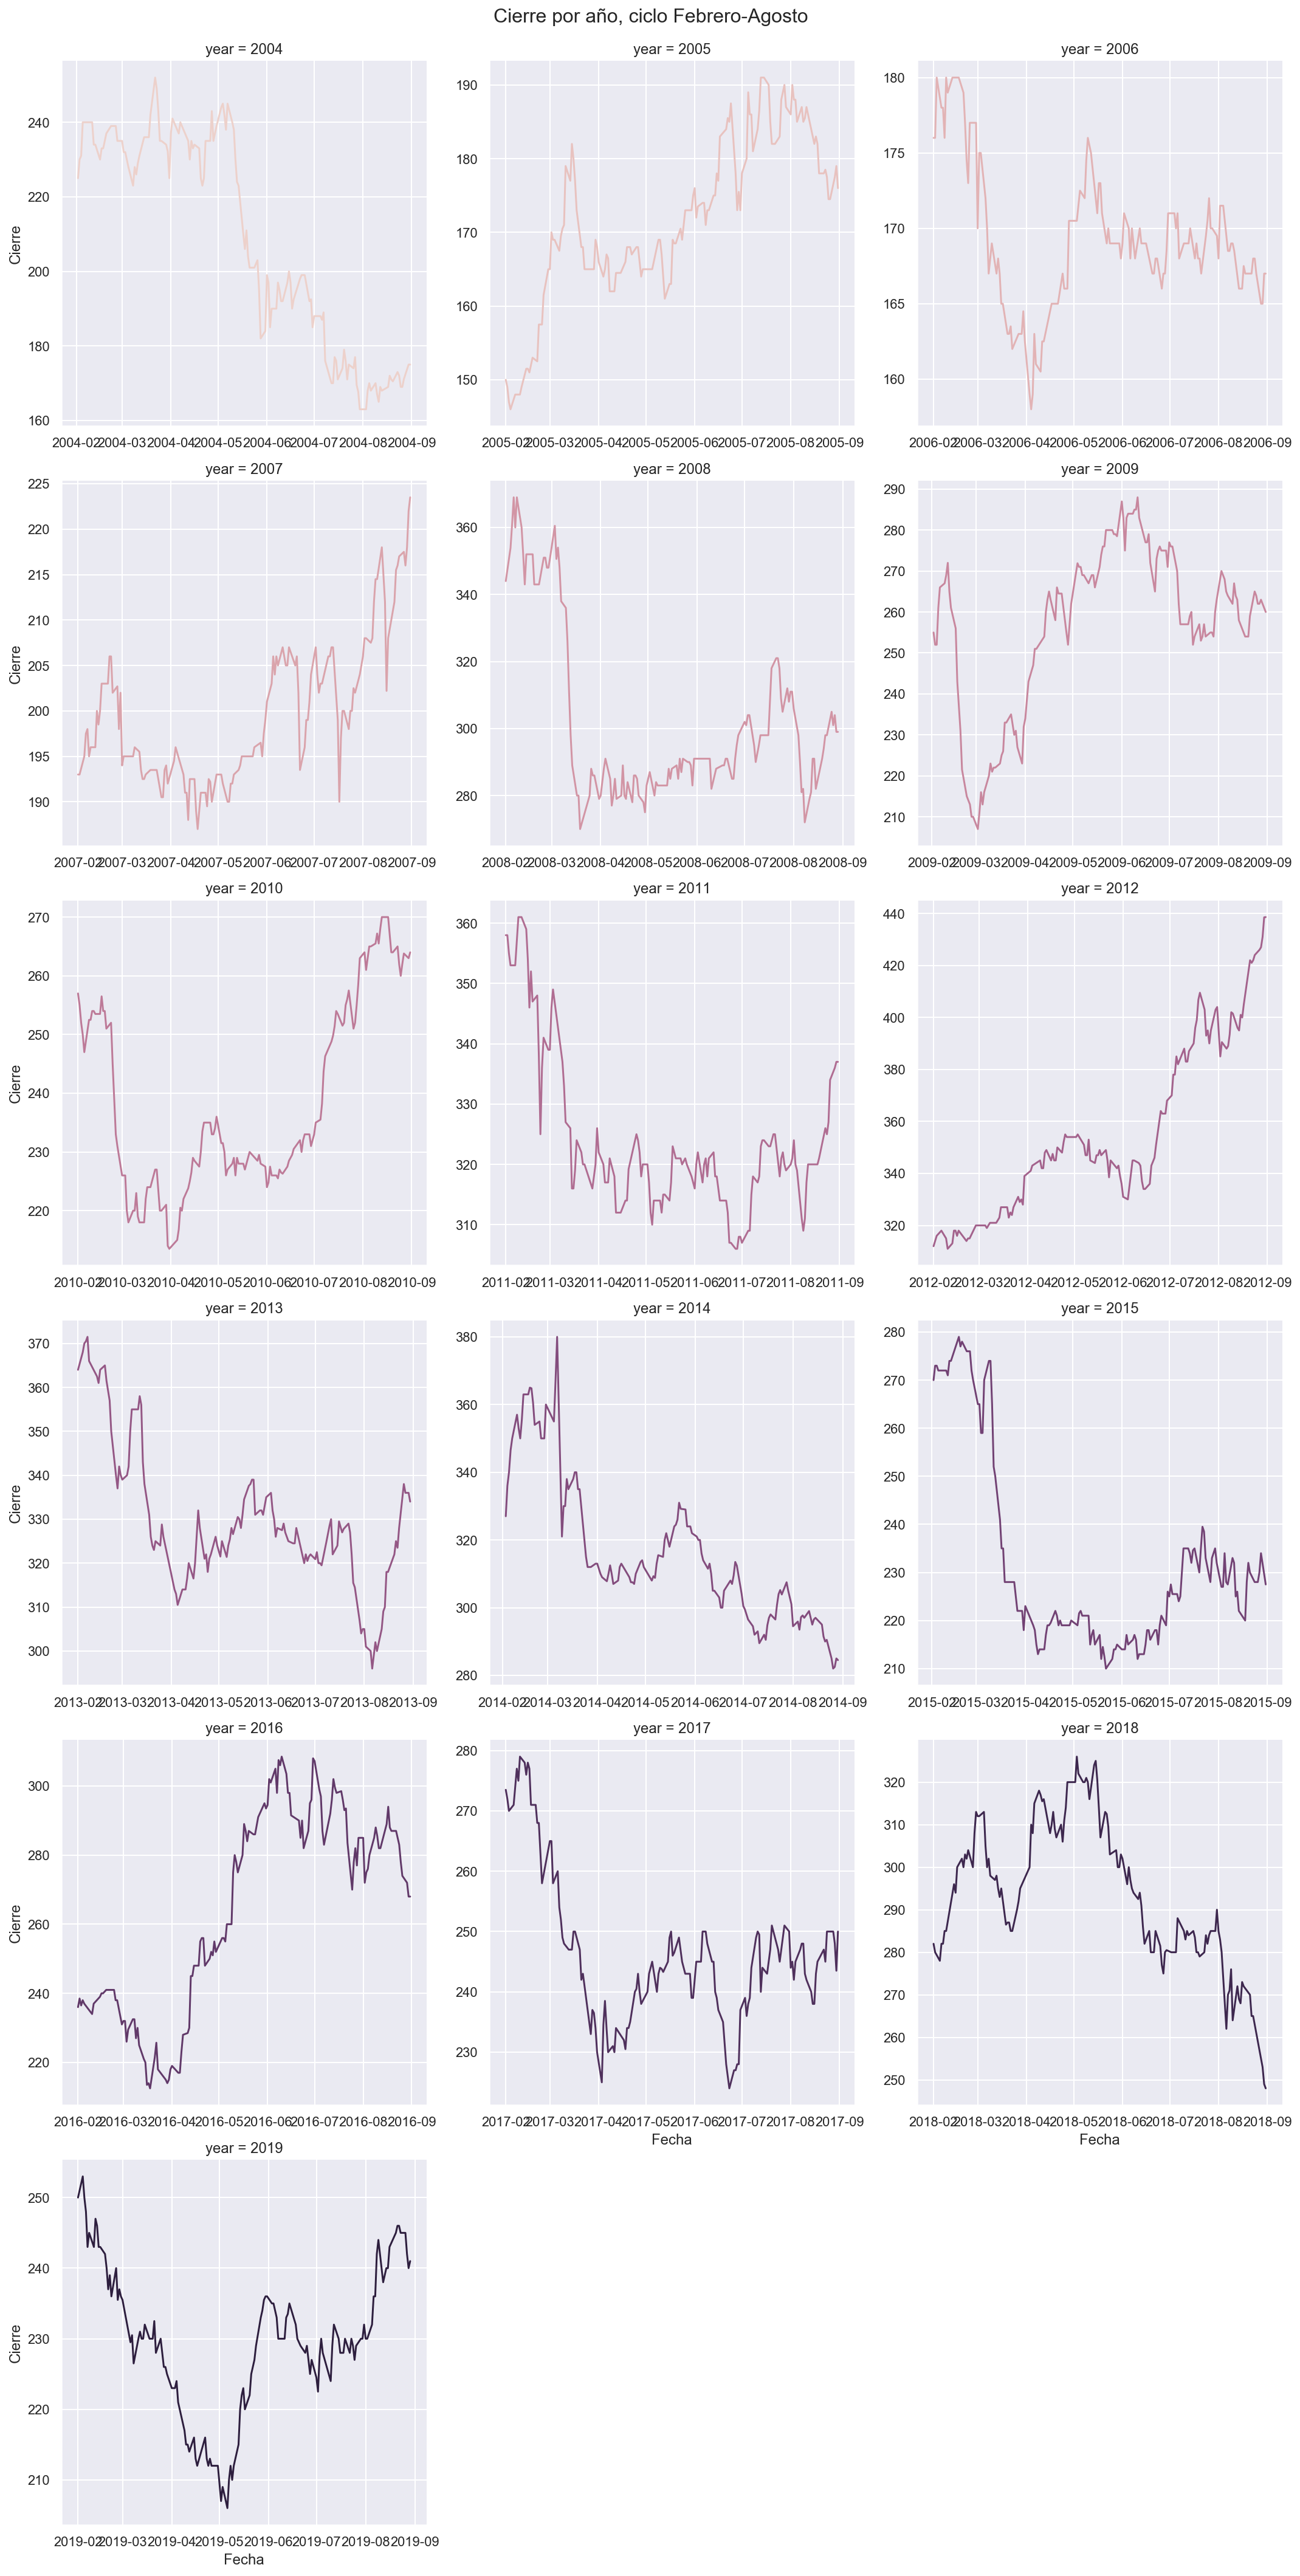

In [8]:
g = sns.relplot(x='Fecha', y='Cierre', col='year', hue='year',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=False,
            kind='line', data=df_seasonal_Feb_Aug.reset_index())

g.fig.suptitle("Cierre por año, ciclo Febrero-Agosto", size=16)
g.fig.subplots_adjust(top=.96);

In [9]:
df_seasonal_Sep_Jan = df.loc[(df.index.month >8) | (df.index.month < 2)]

In [10]:
df_seasonal_Sep_Jan['ciclo'] = np.nan
for i in df_seasonal_Sep_Jan.index.year.unique():
    df_seasonal_Sep_Jan.loc[df[((df.index.month> 8) & (df.index.year == i)) | ((df.index.month < 2) & (df.index.year == i+1))].index,'ciclo'] = i 

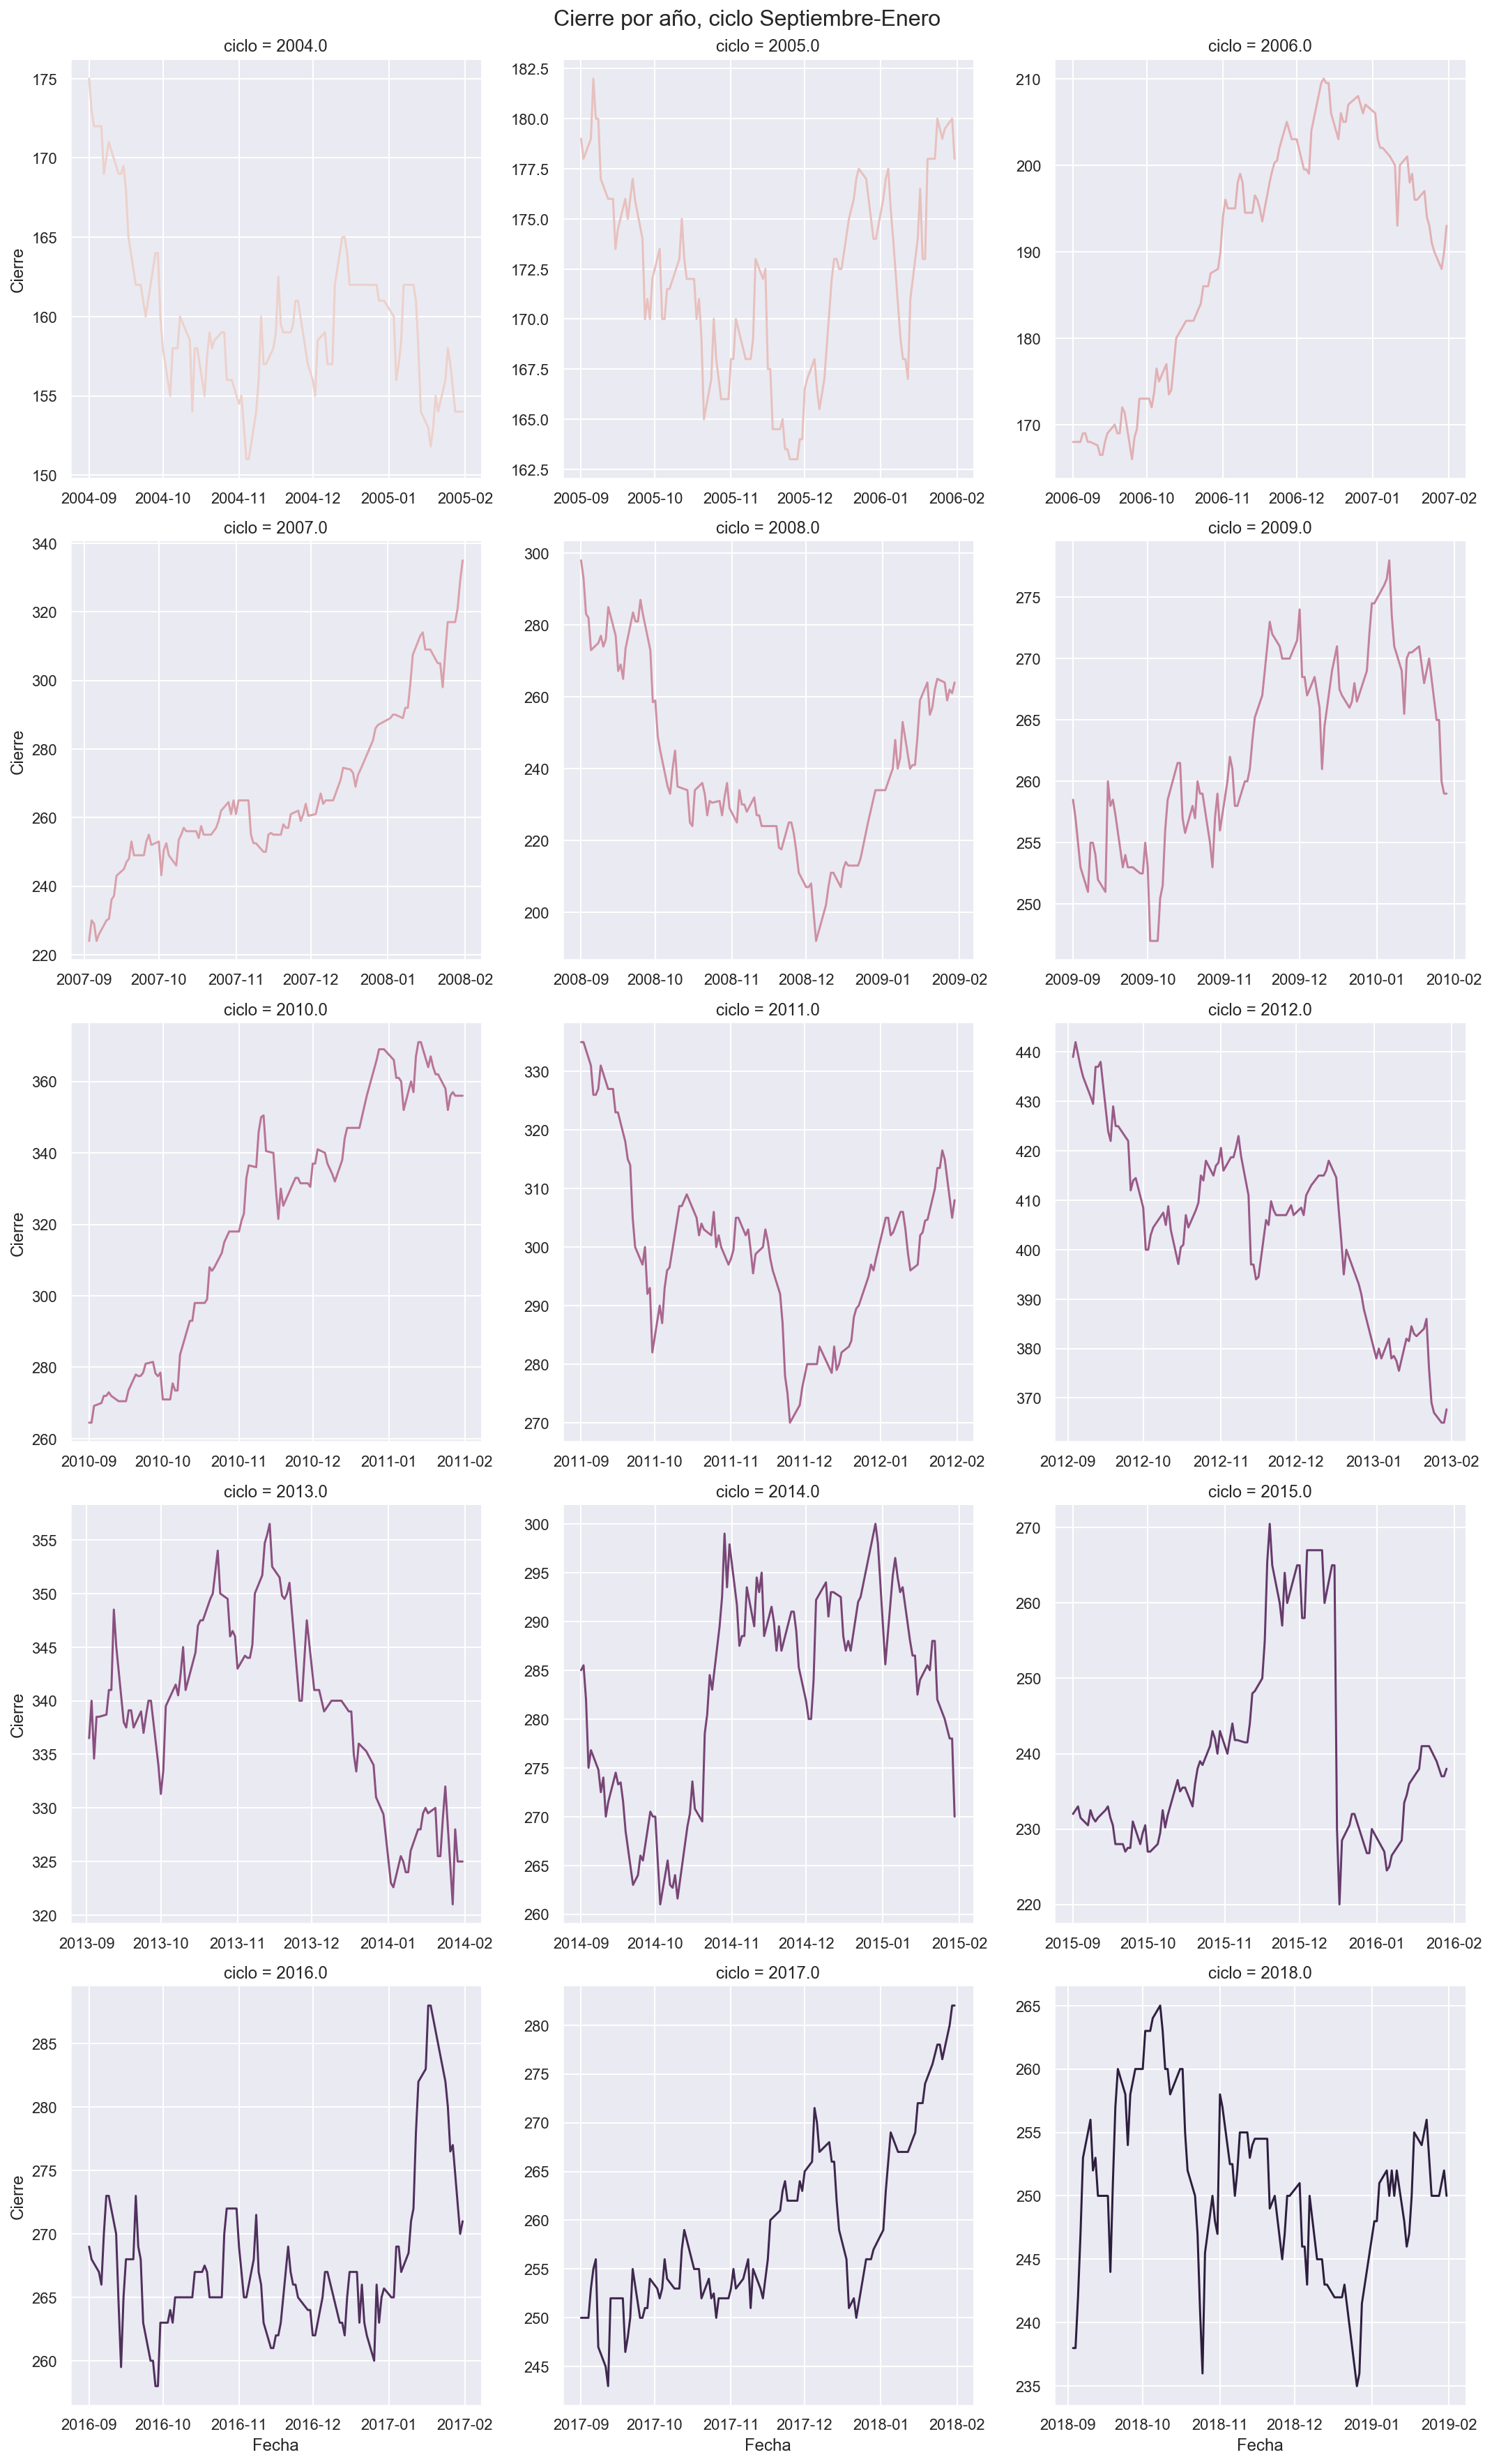

In [11]:
g = sns.relplot(x='Fecha', y='Cierre', col='ciclo', hue='ciclo',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=False,
            kind='line', data=df_seasonal_Sep_Jan.reset_index())

g.fig.suptitle("Cierre por año, ciclo Septiembre-Enero", size=16)
g.fig.subplots_adjust(top=.96);

In [12]:
df['year'] = df.index.year

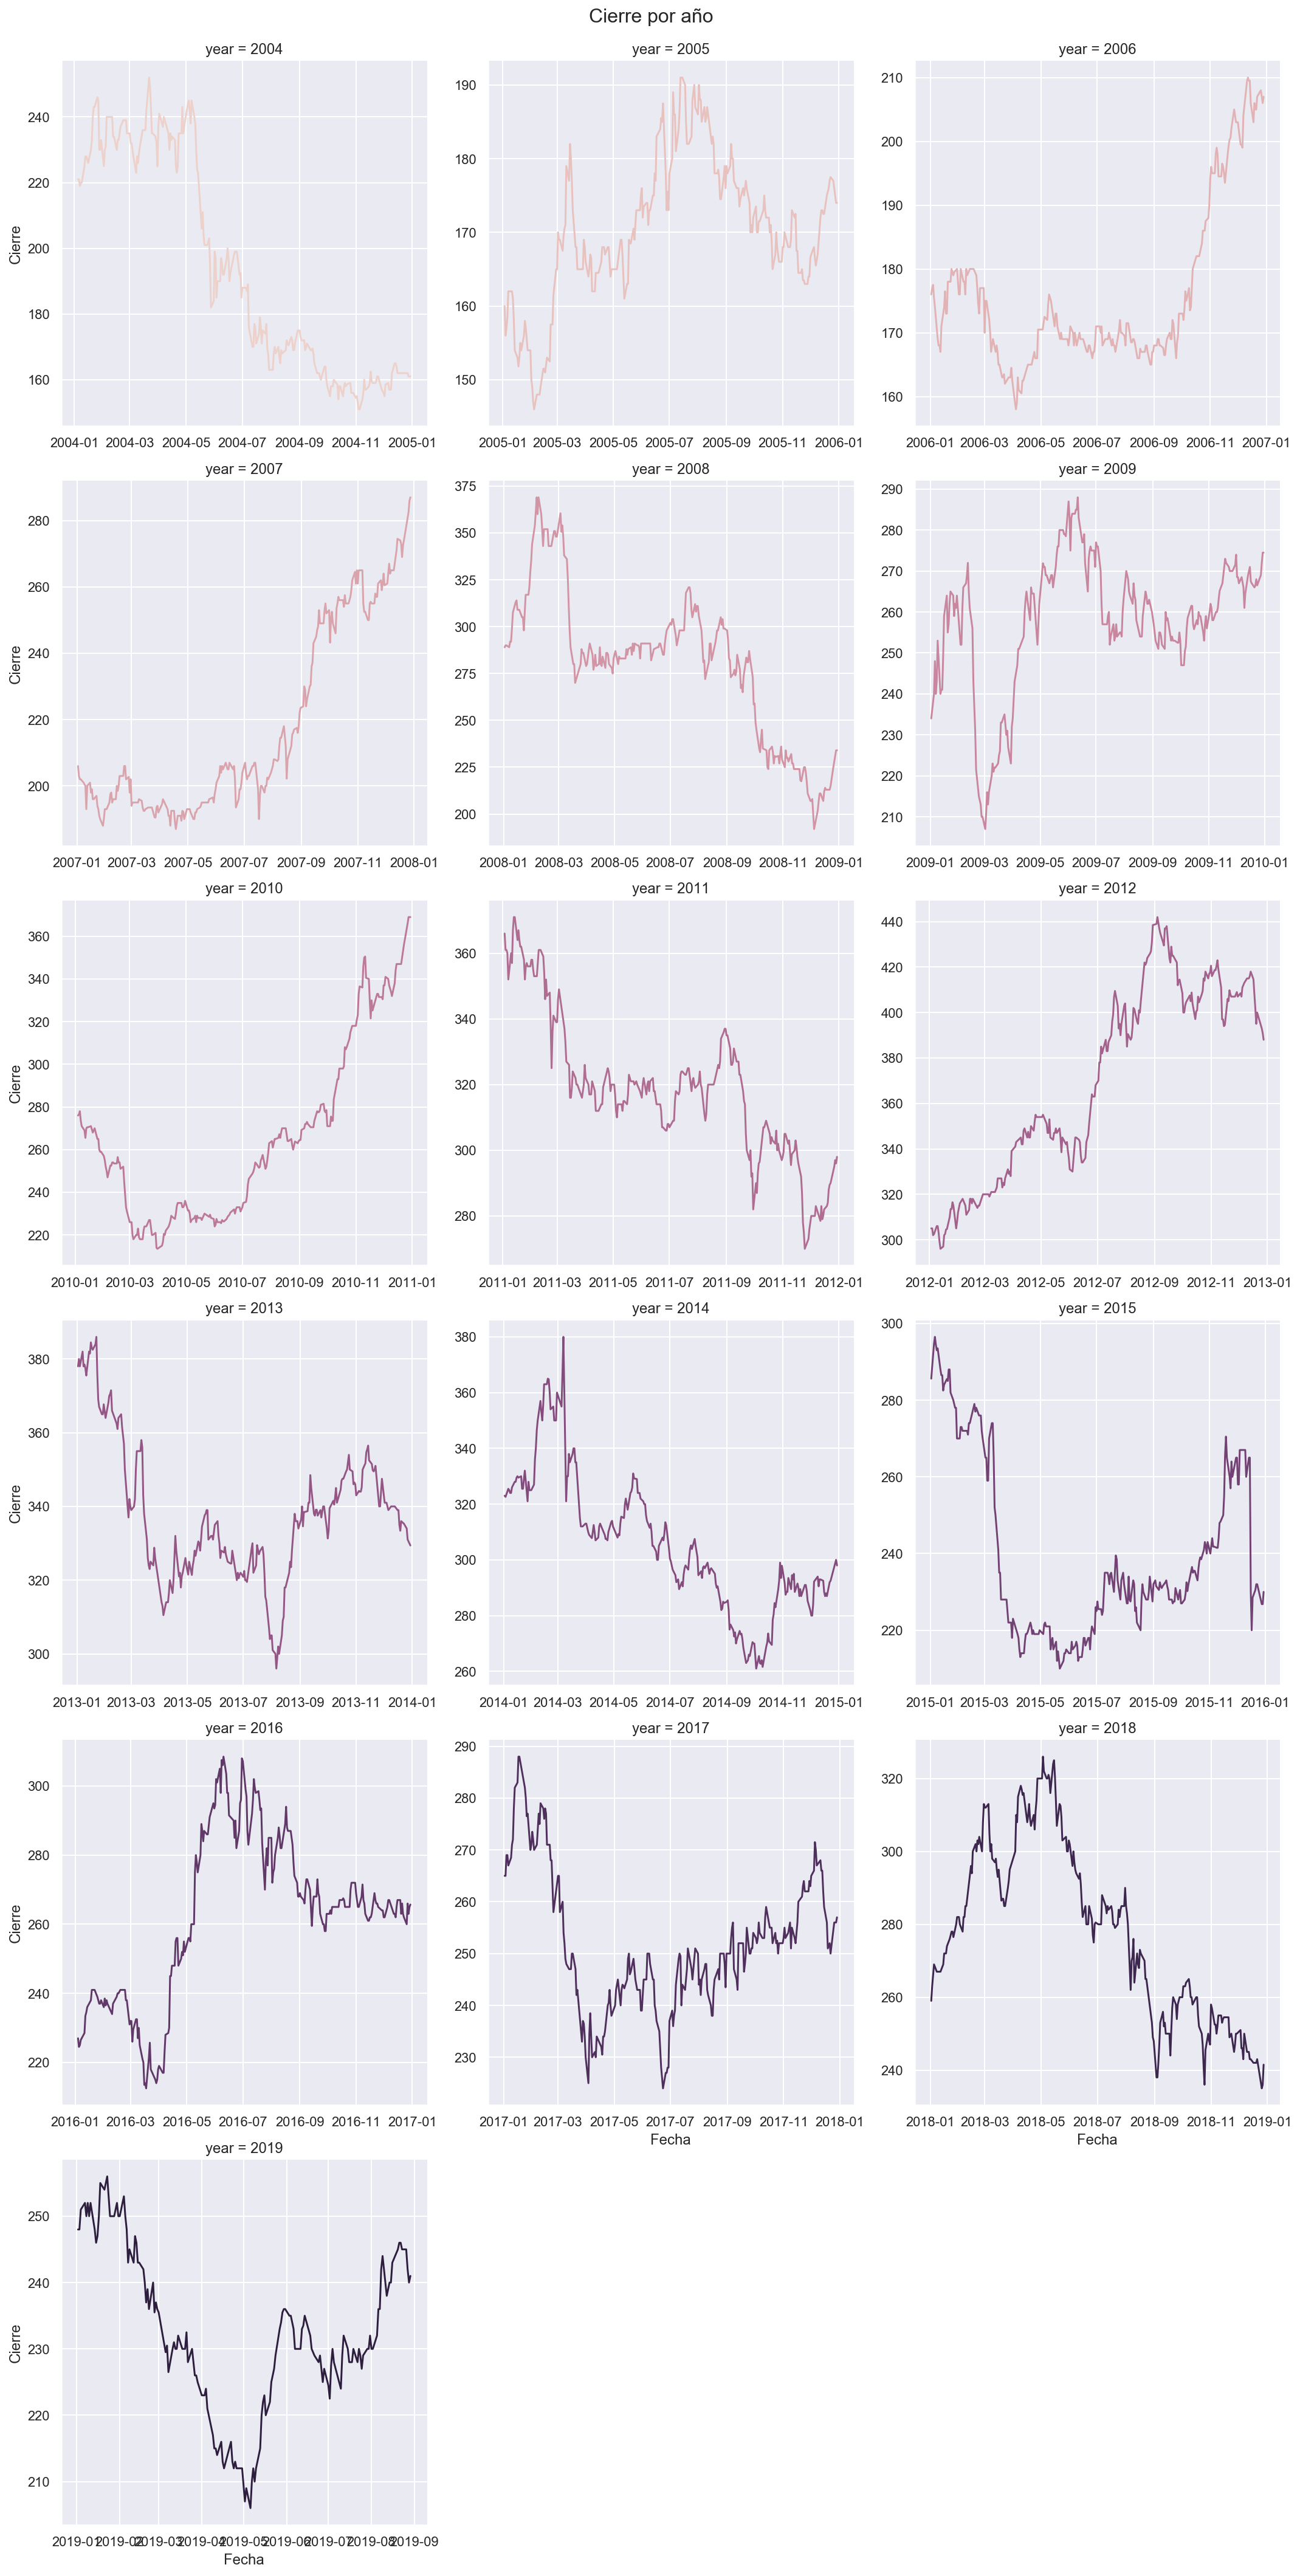

In [13]:
g = sns.relplot(x='Fecha', y='Cierre', col='year', hue='year',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=False,
            kind='line', data=df.reset_index())

g.fig.suptitle("Cierre por año", size=16)
g.fig.subplots_adjust(top=.96);

In [14]:
df_seasonal_first_semester = df.loc[df.index.month <6]

In [15]:
df_seasonal_first_semester['year'] = df_seasonal_first_semester.index.year

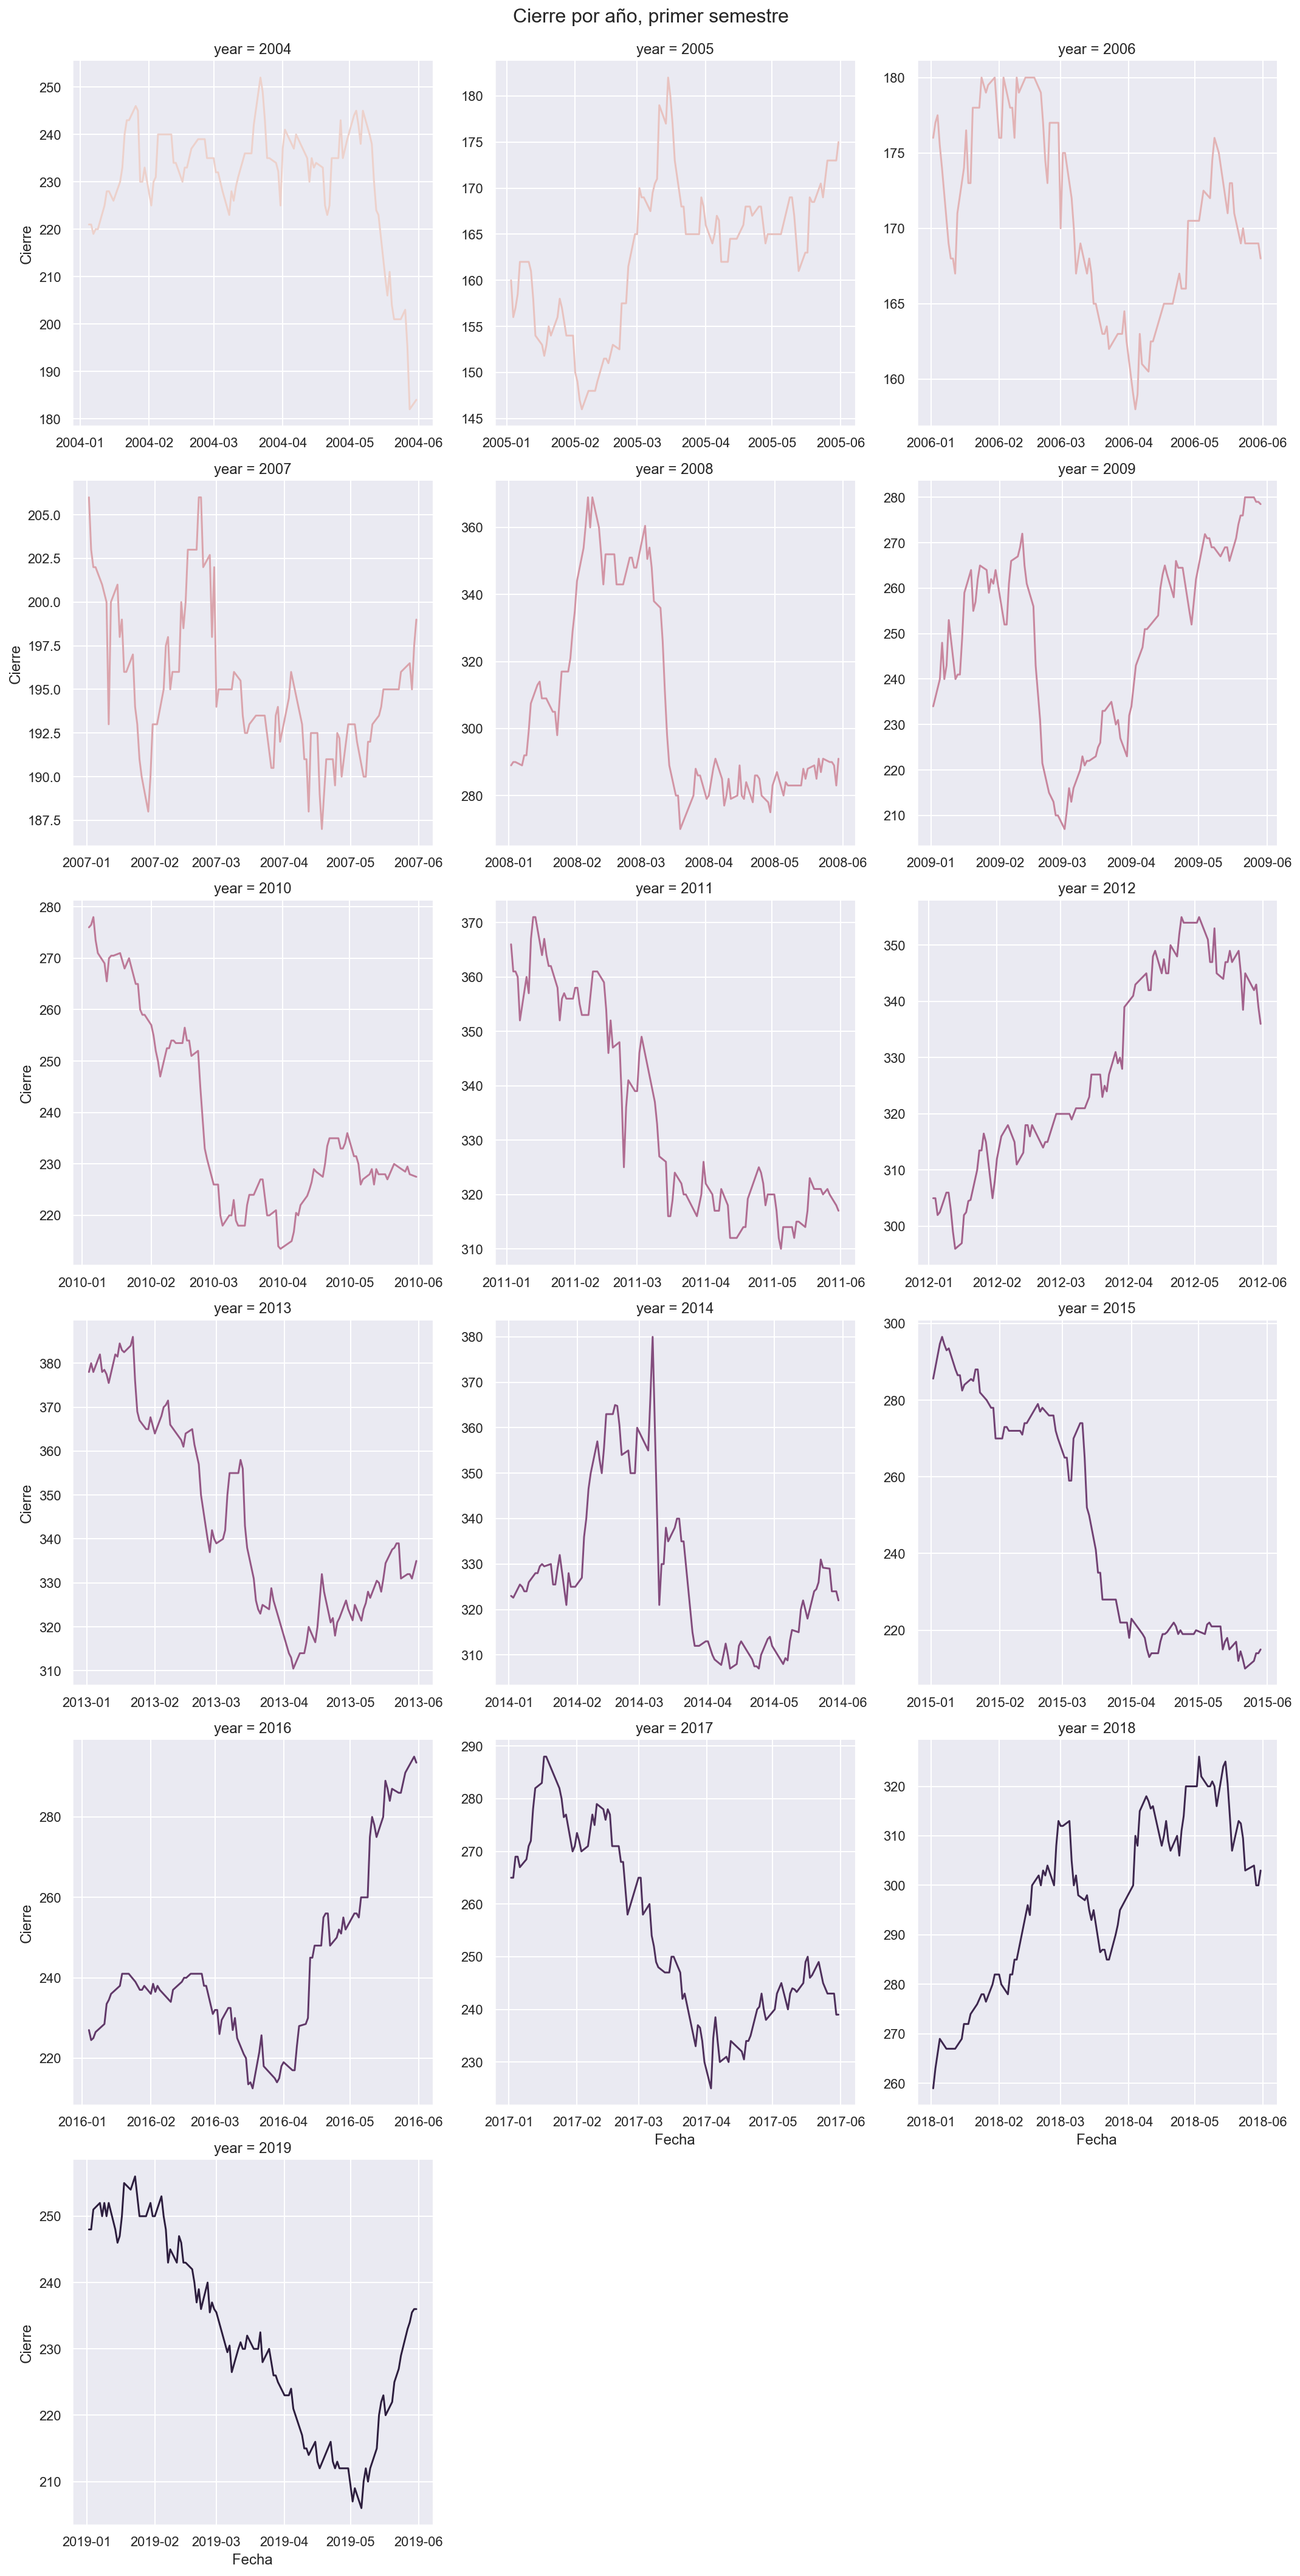

In [16]:
g = sns.relplot(x='Fecha', y='Cierre', col='year', hue='year',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=False,
            kind='line', data=df_seasonal_first_semester.reset_index())

g.fig.suptitle("Cierre por año, primer semestre", size=16)
g.fig.subplots_adjust(top=.96);

In [17]:
df_seasonal_second_semester = df.loc[df.index.month > 6]

In [18]:
df_seasonal_second_semester['year'] = df_seasonal_second_semester.index.year

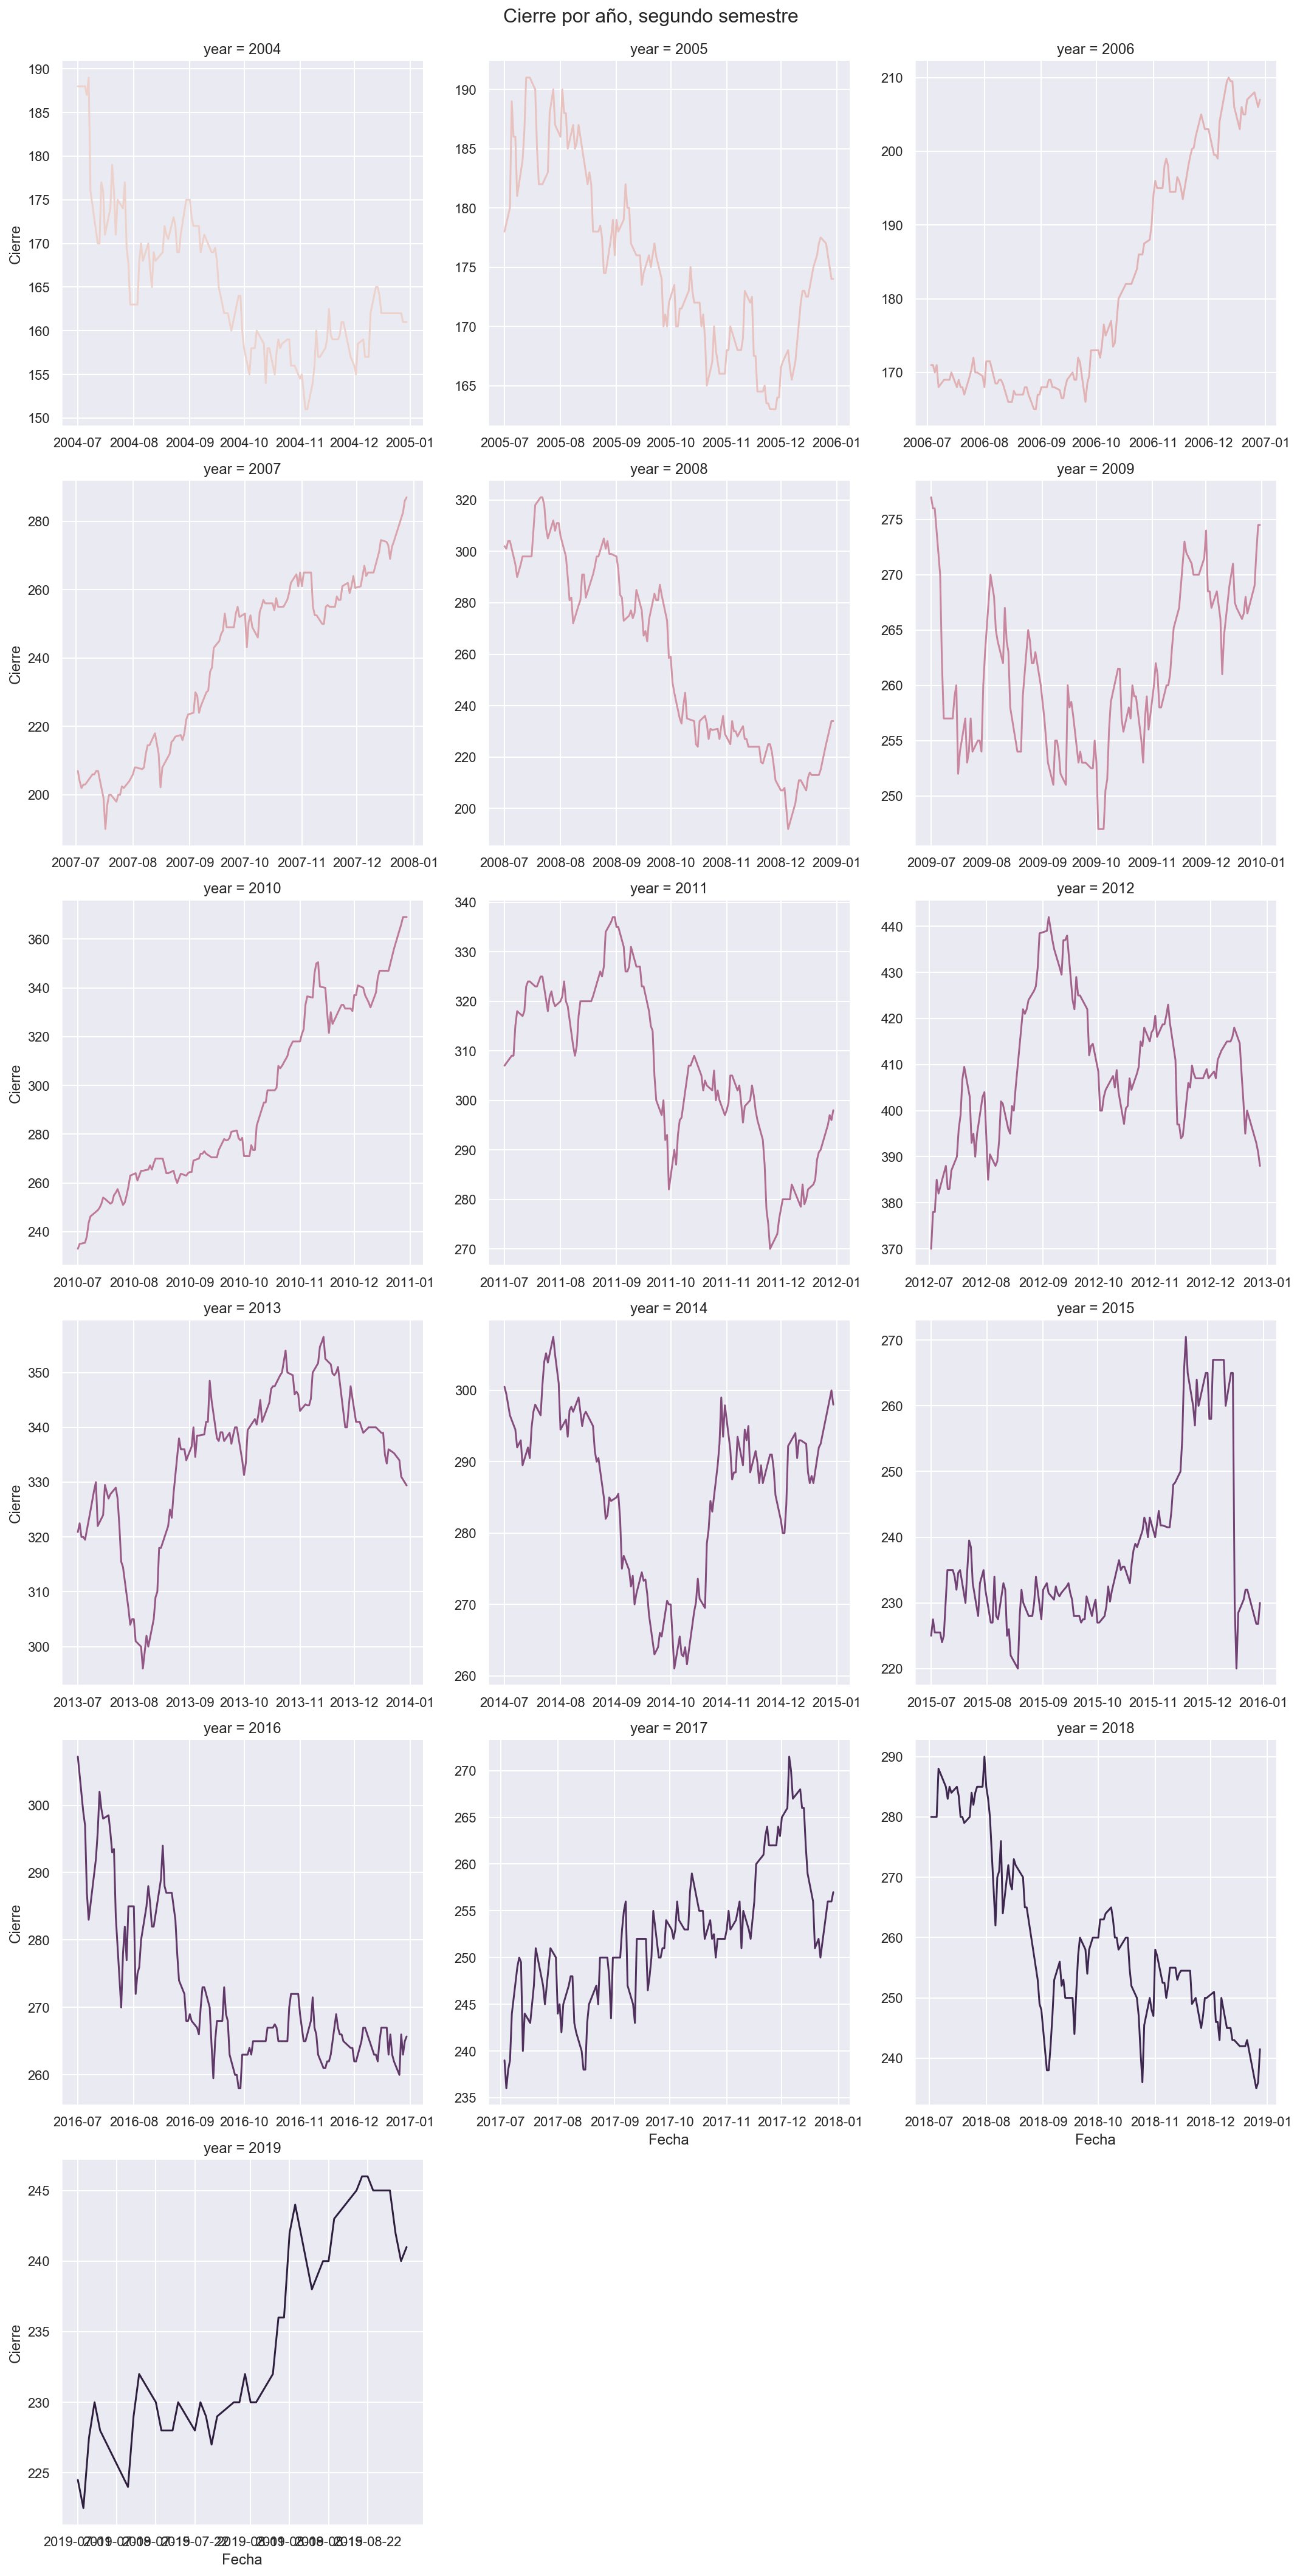

In [19]:
g = sns.relplot(x='Fecha', y='Cierre', col='year', hue='year',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=False,
            kind='line', data=df_seasonal_second_semester.reset_index())

g.fig.suptitle("Cierre por año, segundo semestre", size=16)
g.fig.subplots_adjust(top=.96);

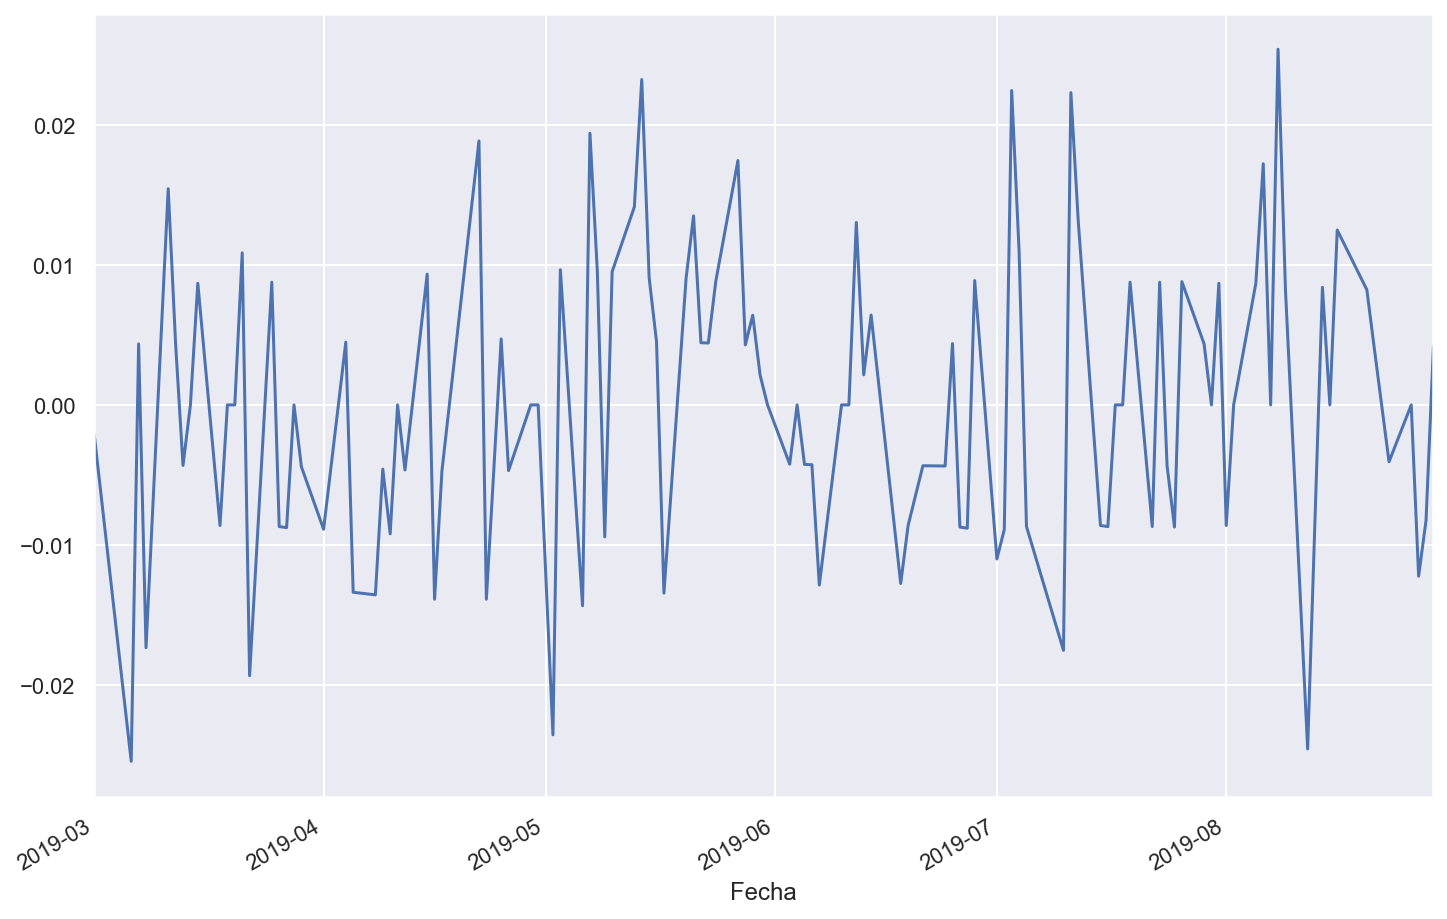

In [20]:
retornos_6_meses.plot();

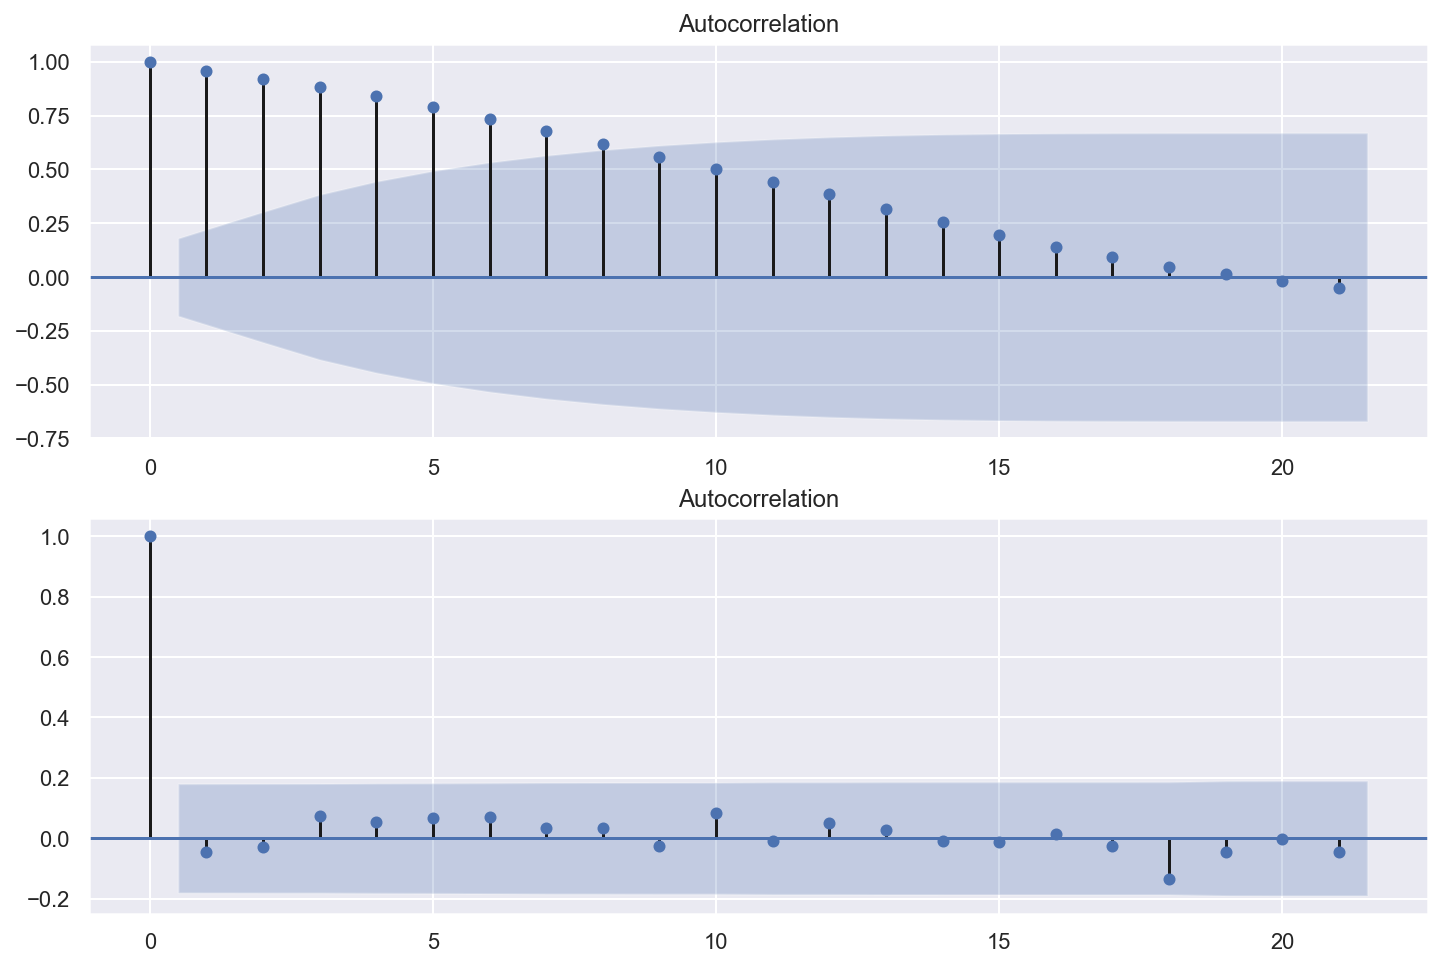

In [21]:
fig, (ax1, ax2) = plt.subplots(2)
sm.graphics.tsa.plot_acf(df.last('6M')['Cierre'], ax=ax1)
sm.graphics.tsa.plot_acf(retornos_6_meses, ax=ax2);

In [22]:
#Parámetros
#ARIMA
p = 1
q = 1
#GARCH
r = 1
s = 1
#Número de predicciones a futuro
n = 122

In [23]:
model_arima = sm.tsa.statespace.SARIMAX(retornos_6_meses.values,order=(p,0,q), seasonal=False)

In [24]:
fit = model_arima.fit()

In [25]:
mean_prediction = fit.forecast(n)

In [26]:
residuos = fit.resid

In [27]:
model = pf.GARCH(residuos,r,s)
x = model.fit()
x.summary()

GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 1                                           Log Likelihood: 368.1785                          
End Date: 117                                           AIC: -728.3571                                    
Number of observations: 117                             BIC: -717.3084                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             0.0001                                                           
q(1)                                 

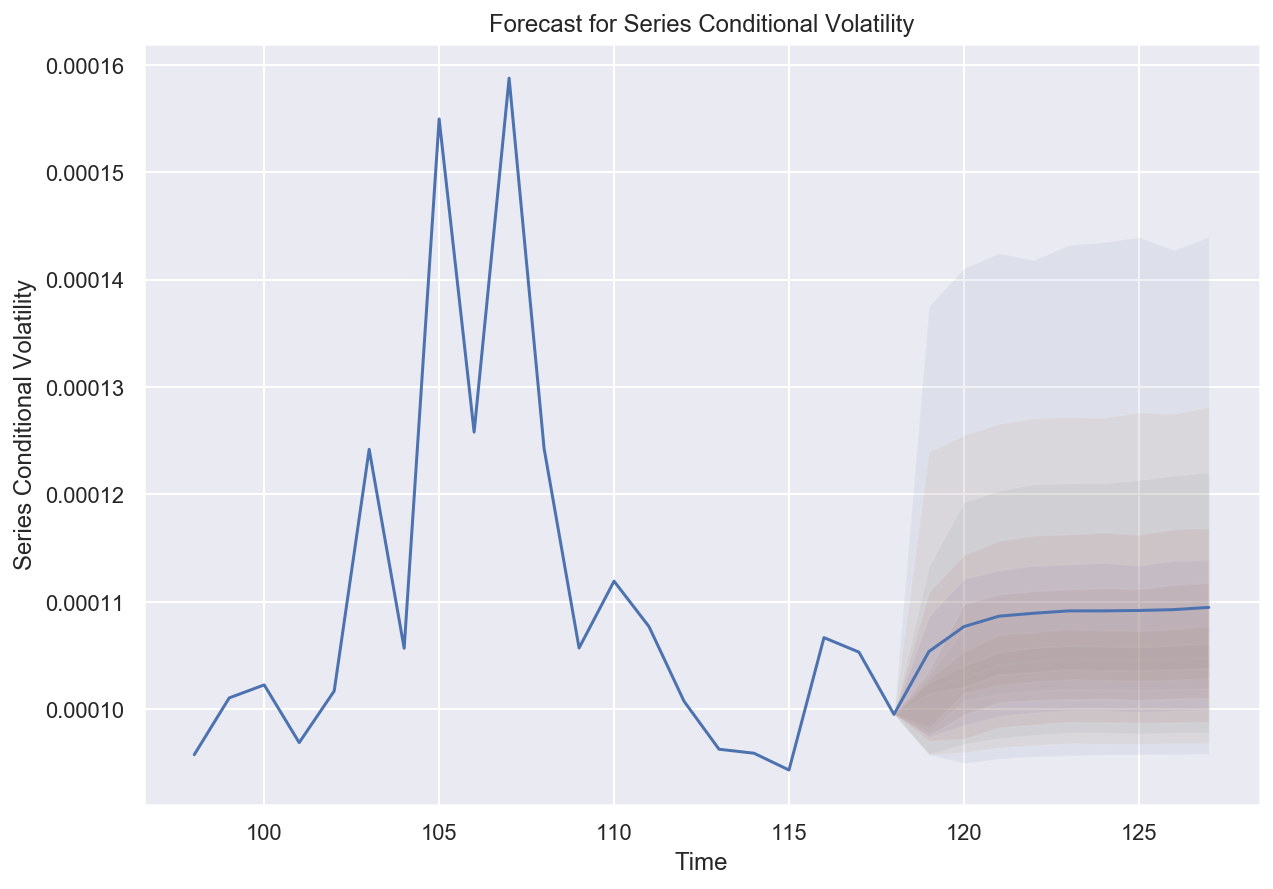

In [28]:
model.plot_predict(h=10)

In [29]:
variance_prediction = model.predict(n)

In [30]:
def predict(mu, var, normal_samples):
    return (mu + normal_samples * np.sqrt(var))

In [31]:
normal_samples = np.random.normal(0,1,n)

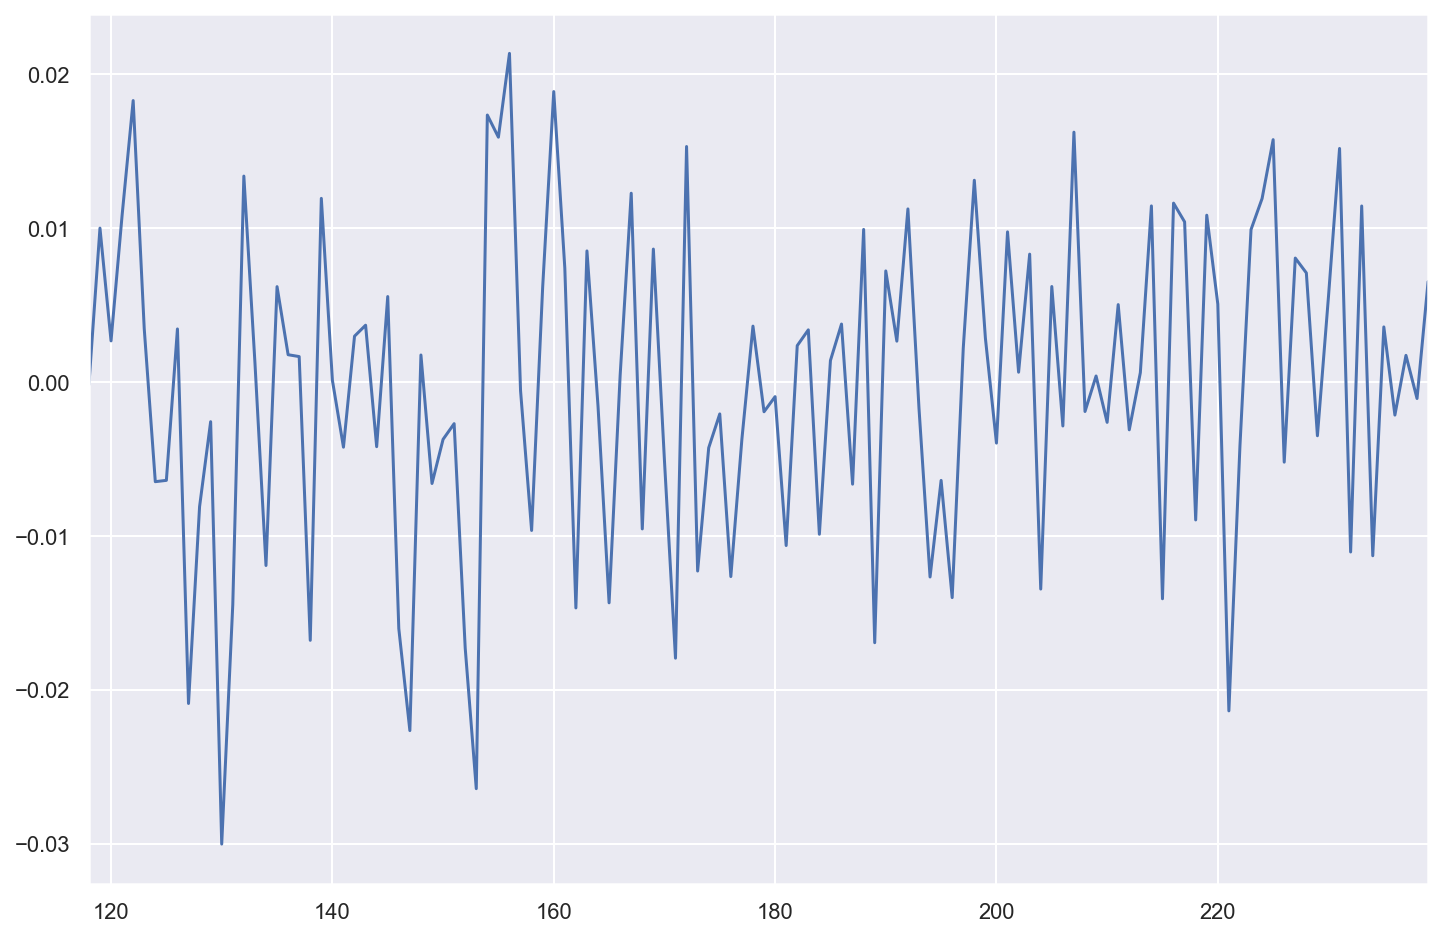

In [32]:
#Predicción de los retornos
predicted_returns = predict(mean_prediction, variance_prediction['Series'], normal_samples)
predicted_returns.plot();

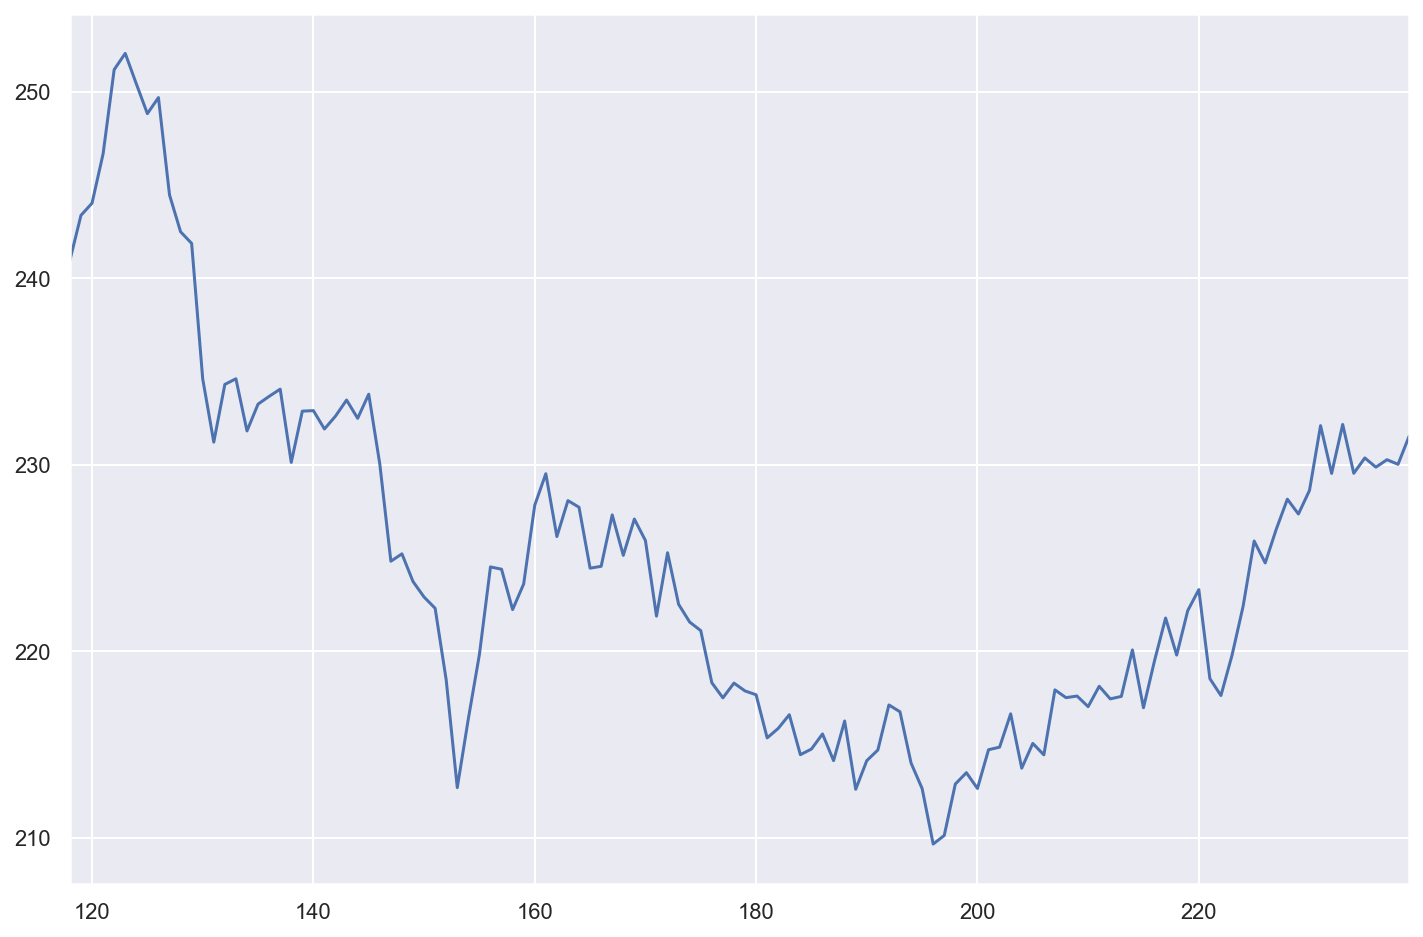

In [33]:
#Predicción del precio de cierre
predicted_close = (1 + predicted_returns).cumprod() * df['Cierre'][-1]
predicted_close.plot();

In [34]:
futuros.sort_index(inplace=True)
daily_returns_futuros = futuros['Cierre'].pct_change().dropna()
daily_returns_futuros = daily_returns_futuros.dropna()

In [35]:
#Error en los retornos ARIMA-GARCH
diff = daily_returns_futuros.reset_index()['Cierre'].values - predicted_returns[:13].values
diff_abs = np.abs(diff)
np.sum(diff_abs)/13

0.01329218068879284

In [36]:
#Error en los retornos si se predice con el último valor
daily_returns_futuros.abs().sum()/13

0.007413082079339508

In [37]:
#Error en el precio de cierre ARIMA-GARCH
diff_close = (futuros.reset_index()['Cierre'][1:].values - predicted_close[:13].values)
diff_close_abs = np.abs(diff_close)
np.sum(diff_close_abs)/13

6.5098936714316

In [38]:
#Error en el precio de cierre si se predice con el último valor
diff_close_last_value = (futuros.reset_index()['Cierre'][1:].values - df['Cierre'][-1])
diff_close_last_value_abs = np.abs(diff_close_last_value)
np.sum(diff_close_last_value_abs)/13

1.8461538461538463